<a href="https://colab.research.google.com/github/Thiago-Reis-Porto/Python-repository/blob/main/Game_recomendation_word_embendings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports to dowload/request_data
import requests as rqts
import time
import json
import gdown 

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#Init

In [ ]:
ID = '5c5mfol096rmlsu6806yn1ionqeoiw'
SECRET = '2l3yhpc8uqtliejf32vkw5v7s332tq'

In [ ]:
url = 'https://id.twitch.tv/oauth2/token'

In [ ]:
r = rqts.post(url, data={'client_id': ID, 'client_secret': SECRET,'grant_type':'client_credentials'})

In [ ]:
access = r.json()
access

{'access_token': 'bpae5440yyn1tocuhzmf2jkcyagwcc',
 'expires_in': 4922963,
 'token_type': 'bearer'}

In [ ]:
at = access['access_token']

In [ ]:
igdb_url = 'https://api.igdb.com/v4/games'

#Utils

In [ ]:
def request_games(fields='*', offset=0, limit=500):
  r = rqts.post(igdb_url, 
              headers={'Client-ID':ID, 'Authorization': f'Bearer {at}'},
              params={'fields': fields, 'offset':offset, 'limit':limit})
  return r.json()

In [ ]:
BY = ''
def filter_by(el):
  if BY in el.keys():
    return True
  return False

In [ ]:
def have_all_keys(keys, dict_elt):
  for key in keys:
    if key not in dict_elt.keys():
      return False
  return True

In [ ]:
def filter_by_keys(el):
  keys = ['name', 'summary', 'storyline', 'cover', 'category', 
          'genres', 'keywords', 'url', 'similar_games']
  return have_all_keys(keys, el)

In [ ]:
columns = ['id', 'name', 'cover', 'genres', 'keywords', 'similar_games', 'storyline', 'summary', 'igdb_url']

In [ ]:
def insert_game_in_df(df, game):
  new_row = {'id': game['id'], 
             'name': game['name'], 
             'cover': 'https:' + game['cover']['url'], 
             'genres': [g['name'] for g in game['genres']],
             'keywords': [k['name'] for k in game['keywords']],
             'similar_games': game['similar_games'],
             'storyline': game['storyline'],
             'summary': game['summary'],
             'igdb_url': game['url']}
  
  df = df.append(new_row, ignore_index=True)
  return df

In [ ]:
# Utitlity functions for removing ASCII characters, converting lower case, 
# removing stop words, html and punctuation

def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [ ]:
def clean_text(df, key_name):
  cleaned = 'cleaned_' + key_name
  df[cleaned] = df[key_name].apply(_removeNonAscii)
  df[cleaned] = df[cleaned].apply( make_lower_case)
  df[cleaned] = df[cleaned].apply(remove_stop_words)
  df[cleaned] = df[cleaned].apply(remove_punctuation)
  df[cleaned] = df[cleaned].apply(remove_html)

In [ ]:
# Generate the average word2vec for the each game description
def vectors(df, key, model):
    
    # Creating a list for storing the vectors (description into vectors)
    word_embeddings = []

    # Reading the each game description 
    for line in df[key]:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = model.wv[word]
                else:
                    avgword2vec = avgword2vec + model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)
    return word_embeddings

In [ ]:
def recommendations(df, title, word_embeddings):
    def __print_status(row, similar=None):
        response = rqts.get(row['cover'])
        img = Image.open(BytesIO(response.content))
        name = row['name'] 
        print(name)
        genres = ' '.join(row['genres'])
        print(f'Genres: {genres}')
        plt.figure(figsize=(2,2))
        if similar:
          print(f'In Igdb Similar Games: {name in similar}')
        plt.imshow(img, interpolation='nearest')      
        plt.show()

    similar = get_similiar_games(title)

    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # taking the title and book image link and store in new data frame called books
    games = df[['name', 'cover', 'keywords', 'genres', 'similar_games']]

    #Reverse mapping of the index
    indices = pd.Series(df.index, index = df['name'])
    
    query = f'name == "{title}"'
    q = df.query(query)
    idx = df.index.get_loc(q.index.values[0])

    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[:6]
    game_indices = [i[0] for i in sim_scores]
    
    recommend = games.iloc[game_indices]
    game = recommend.iloc[0]
    __print_status(game, similar=None)
    for index, row in recommend[1:].iterrows():
      __print_status(row, similar=similar)
      

In [ ]:
def get_similiar_games(name):
  similar_games = []
  game = df[df['name'] == name].head(1)
  for g in game['similar_games'].values[0]:
    similar_games.append(g['name'])
  return similar_games

#Get Data from IGDB (not needed)

In [ ]:
fields = """name, summary, storyline, cover.url,
            category, genres.name, keywords.name,
            url, similar_games.name"""

In [ ]:
games_data = []
i = 0;
while True:
  r = request_games(fields, offset=i, limit=500)
  if not r:
    break

  games_data += r
  if i % 4:
    time.sleep(1)
  i+=500

In [ ]:
len(games_data)

210539

In [ ]:
with open('games_data.json', 'w') as fout:
  json.dump(games_data, fout)

#Data

##Get Data

In [ ]:
!gdown 1FstYo3VyyUWbAMGbAxNN2_ydOqc7tks0

Downloading...
From: https://drive.google.com/uc?id=1FstYo3VyyUWbAMGbAxNN2_ydOqc7tks0
To: /content/games_data.json
100% 325M/325M [00:01<00:00, 239MB/s]


In [ ]:
with open('games_data.json',) as f:
  games_data = json.load(f)

In [ ]:
len(games_data)

210539

##Filter to keep only games with all needed keys

In [ ]:
filtered = [*filter(filter_by_keys, games_data)]

In [ ]:
len(filtered)

13487

###Set an dataframe and save the csv

In [ ]:
df_filtered = pd.DataFrame()
for game in filtered:
  df_filtered = insert_game_in_df(df_filtered, game)

In [ ]:
df = df_filtered.set_index('id')
df.head()

,name,cover,genres,keywords,similar_games,storyline,summary,igdb_url
id,,,,,,,,
22704.0,Orwell,https://images.igdb.com/igdb/image/upload/t_th...,"[Simulator, Adventure, Indie]","[dystopian, episodic, sci-fi, adventure, simul...","[{'id': 9789, 'name': 'RimWorld'}, {'id': 1320...",Big Brother has arrived - and it’s you. Invest...,Using the new governmental security program th...,https://www.igdb.com/games/orwell
18248.0,Beat City,https://images.igdb.com/igdb/image/upload/t_th...,[Music],"[rhythm, minigames, music/rhythm, minigame col...","[{'id': 11711, 'name': 'The Idolmaster: Cinder...","Can you feel the beat? Life, color, and happin...",A rhythm-based mini-game collection for the DS...,https://www.igdb.com/games/beat-city
27056.0,Em-8ER,https://images.igdb.com/igdb/image/upload/t_th...,"[Shooter, Indie]","[first person shooter, crafting, mech combat, ...","[{'id': 142, 'name': 'Star Wars: Battlefront I...",Humanity had colonized the nearby stars for hu...,What is EM-8ER? (pronounced Ember): \n \nEM-8E...,https://www.igdb.com/games/em-8er
222552.0,Solomon's Ring: Kaze no Shou,https://images.igdb.com/igdb/image/upload/t_th...,[Visual Novel],"[female protagonist, demons, multiple endings,...","[{'id': 64162, 'name': 'Solomon's Ring: Hi no ...","Based on the Legend of Solomon, who was known ...",Otome game by Plan Peace for PSP.,https://www.igdb.com/games/solomons-ring-kaze-...
64162.0,Solomon's Ring: Hi no Shou,https://images.igdb.com/igdb/image/upload/t_th...,[Visual Novel],"[female protagonist, demons, multiple endings,...","[{'id': 72680, 'name': 'Angelique Etoile'}, {'...","Based on the Legend of Solomon, who was known ...",Otome game by Plan Peace. The first in the Sol...,https://www.igdb.com/games/solomons-ring-hi-no...


In [ ]:
df.to_csv('filtered_game.csv')

##Load csv filtered DataFrame

In [ ]:
!gdown 1GSk_lClcDdTmcqh3pf-7FS_LtvAWS5RA

Downloading...
From: https://drive.google.com/uc?id=1GSk_lClcDdTmcqh3pf-7FS_LtvAWS5RA
To: /content/filtered_game.csv
100% 26.8M/26.8M [00:00<00:00, 113MB/s] 


In [ ]:
import ast

In [ ]:
df = pd.read_csv('filtered_game.csv', 
                 index_col='id', 
                 converters={'genres':ast.literal_eval, 
                             'keywords': ast.literal_eval,
                             'similar_games': ast.literal_eval})
df.index = df.index.astype(int)
df.head()

,name,cover,genres,keywords,similar_games,storyline,summary,igdb_url
id,,,,,,,,
22704,Orwell,https://images.igdb.com/igdb/image/upload/t_th...,"[Simulator, Adventure, Indie]","[dystopian, episodic, sci-fi, adventure, simul...","[{'id': 9789, 'name': 'RimWorld'}, {'id': 1320...",Big Brother has arrived - and it’s you. Invest...,Using the new governmental security program th...,https://www.igdb.com/games/orwell
18248,Beat City,https://images.igdb.com/igdb/image/upload/t_th...,[Music],"[rhythm, minigames, music/rhythm, minigame col...","[{'id': 11711, 'name': 'The Idolmaster: Cinder...","Can you feel the beat? Life, color, and happin...",A rhythm-based mini-game collection for the DS...,https://www.igdb.com/games/beat-city
27056,Em-8ER,https://images.igdb.com/igdb/image/upload/t_th...,"[Shooter, Indie]","[first person shooter, crafting, mech combat, ...","[{'id': 142, 'name': 'Star Wars: Battlefront I...",Humanity had colonized the nearby stars for hu...,What is EM-8ER? (pronounced Ember): \n \nEM-8E...,https://www.igdb.com/games/em-8er
222552,Solomon's Ring: Kaze no Shou,https://images.igdb.com/igdb/image/upload/t_th...,[Visual Novel],"[female protagonist, demons, multiple endings,...","[{'id': 64162, 'name': 'Solomon's Ring: Hi no ...","Based on the Legend of Solomon, who was known ...",Otome game by Plan Peace for PSP.,https://www.igdb.com/games/solomons-ring-kaze-...
64162,Solomon's Ring: Hi no Shou,https://images.igdb.com/igdb/image/upload/t_th...,[Visual Novel],"[female protagonist, demons, multiple endings,...","[{'id': 72680, 'name': 'Angelique Etoile'}, {'...","Based on the Legend of Solomon, who was known ...",Otome game by Plan Peace. The first in the Sol...,https://www.igdb.com/games/solomons-ring-hi-no...


In [ ]:
df.index = df.index.astype(int)

In [ ]:
df.shape

(13487, 8)

#Pre Process data

In [ ]:
df = df.dropna()
df.shape

(13481, 8)

In [ ]:
clean_text(df, 'summary')
clean_text(df, 'storyline')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13481 entries, 22704 to 119825
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               13481 non-null  object
 1   cover              13481 non-null  object
 2   genres             13481 non-null  object
 3   keywords           13481 non-null  object
 4   similar_games      13481 non-null  object
 5   storyline          13481 non-null  object
 6   summary            13481 non-null  object
 7   igdb_url           13481 non-null  object
 8   cleaned_summary    13481 non-null  object
 9   cleaned_storyline  13481 non-null  object
dtypes: object(10)
memory usage: 1.1+ MB


#Modeling

###Corpus

In [ ]:
corpus_summary = df['cleaned_summary'].str.split().to_list()
corpus_storyline = df['cleaned_storyline'].str.split().to_list()
corpus_summary_storyline = [x + y for x, y in zip(corpus_summary, corpus_storyline)]
corpus_gnr_smry_stry = [x + y for x, y in zip(df['genres'].to_list(), corpus_summary_storyline)]
corpus_nm_gnr_smry_stry = [[x] + y for x, y in zip(df['name'], corpus_gnr_smry_stry)]

In [ ]:
df['summary_storyline'] = corpus_summary_storyline
df['summary_storyline'] = df['summary_storyline'].str.join(' ')

In [ ]:
df['gnr_smry_stry'] = corpus_gnr_smry_stry
df['gnr_smry_stry'] = df['gnr_smry_stry'].str.join(' ')

In [ ]:
df['nm_gnr_smry_stry'] = corpus_nm_gnr_smry_stry
df['nm_gnr_smry_stry'] = df['nm_gnr_smry_stry'].str.join(' ')

##Word2vec

In [ ]:
#http://vectors.nlpl.eu/repository/

In [ ]:
# Downloading the Google pretrained Word2Vec Model
!wget http://vectors.nlpl.eu/repository/11/1.zip
!unzip 1.zip

--2022-11-27 14:30:04--  http://vectors.nlpl.eu/repository/11/1.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5700887510 (5.3G) [application/zip]
Saving to: ‘1.zip’

1.zip               100%[===================>]   5.31G  22.5MB/s    in 4m 3s   

2022-11-27 14:34:08 (22.4 MB/s) - ‘1.zip’ saved [5700887510/5700887510]

Archive:  1.zip
  inflating: meta.json               
  inflating: model.bin               
  inflating: model.txt               
  inflating: README                  


In [ ]:
PRE_MODEL = 'model.bin'

In [ ]:
MODEL_CFG = {'size': 300,
             'window':5,
             'min_count': 2,
             'workers':-1}

In [ ]:
def train_with_corpus(corpus, epochs=5, pre_model=PRE_MODEL, model_cfg=MODEL_CFG):
  # Training our corpus with Google Pretrained Model
  model = Word2Vec(**model_cfg)
  model.build_vocab(corpus)
  model.intersect_word2vec_format(pre_model, lockf=1.0, binary=True)
  model.train(corpus, 
              total_examples = model.corpus_count, 
              epochs = epochs)
  return model


###Recomendation

In [ ]:
game =  df.sample(1)
game.name.values[0]

'Animal Hospital'

####Summary

In [ ]:
model = train_with_corpus(corpus_summary)

In [ ]:
word_embeddings = vectors(df, 'cleaned_summary', model)

In [ ]:
name = "Baldur's Gate II: Shadows of Amn"


Baldur's Gate II: Shadows of Amn
Genres: Role-playing (RPG)


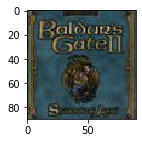

Total War: Warhammer II
Genres: Real Time Strategy (RTS) Strategy
In Igdb Similar Games: False


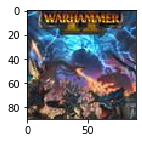

Baldur's Gate: Dark Alliance II
Genres: Role-playing (RPG) Hack and slash/Beat 'em up Adventure
In Igdb Similar Games: True


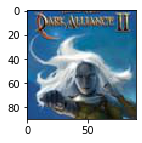

Steins;Gate 0
Genres: Adventure Visual Novel
In Igdb Similar Games: False


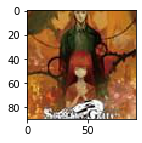

Perdition's Gate
Genres: Shooter
In Igdb Similar Games: False


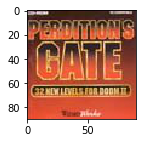

Dudley and the Mysterious Tower
Genres: Puzzle Adventure
In Igdb Similar Games: False


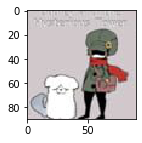

In [ ]:
recommendations(df, name, word_embeddings)

In [ ]:
name = 'Sonic the Hedgehog 4: Episode I'

Sonic the Hedgehog 4: Episode I
Genres: Platform Adventure Arcade


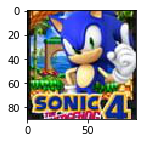

Sonic Generations: Collector's Edition
Genres: Pinball Adventure
In Igdb Similar Games: False


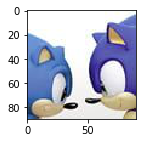

Sonic: After the Sequel
Genres: Platform Adventure
In Igdb Similar Games: False


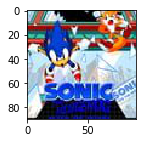

Sonic Generations: White Time and Space 20th Anniversary Set
Genres: Platform Adventure
In Igdb Similar Games: False


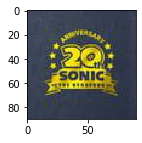

Sonic: Before the Sequel
Genres: Platform Adventure
In Igdb Similar Games: False


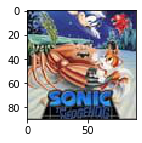

Sonic Rush
Genres: Platform
In Igdb Similar Games: False


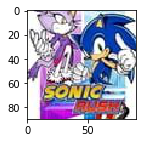

In [ ]:
recommendations(df, name, word_embeddings)

Dark Souls III
Genres: Role-playing (RPG) Adventure


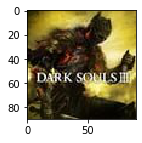

The Dark Eye: Memoria
Genres: Point-and-click Puzzle Adventure Indie
In Igdb Similar Games: False


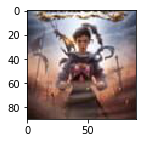

Runes of Magic
Genres: Role-playing (RPG) Adventure Indie
In Igdb Similar Games: False


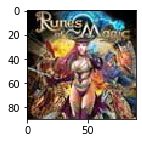

King's Quest: Chapter 2 - A Rubble Without a Cause
Genres: Puzzle Adventure
In Igdb Similar Games: False


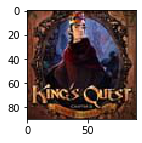

Metal Gear Solid 3: Snake Eater
Genres: Shooter Tactical Adventure
In Igdb Similar Games: False


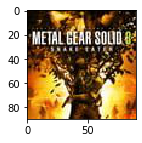

Wizardry: Bane of the Cosmic Forge
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


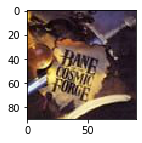

In [ ]:
recommendations(df, "Dark Souls III", word_embeddings)

Star Wars: The Old Republic - Shadow of Revan
Genres: Role-playing (RPG) Adventure


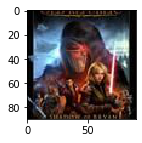

Star Wars: The Old Republic - Knights of the Eternal Throne
Genres: Role-playing (RPG)
In Igdb Similar Games: False


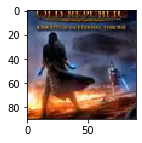

Star Wars: The Old Republic - Onslaught
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


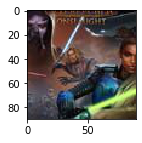

Star Wars: The Old Republic - Legacy of the Sith
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


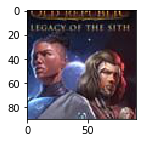

Star Wars: Knights of the Old Republic II - The Sith Lords
Genres: Role-playing (RPG) Strategy Adventure
In Igdb Similar Games: False


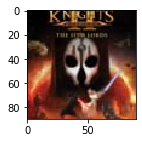

Star Wars: Knights of the Old Republic
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


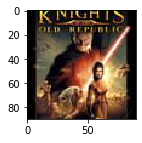

In [ ]:
recommendations(df, 'Star Wars: The Old Republic - Shadow of Revan', word_embeddings)

####Storyline

In [ ]:
model = train_with_corpus(corpus_storyline)

In [ ]:
word_embeddings = vectors(df, 'cleaned_storyline', model)

Baldur's Gate II: Shadows of Amn
Genres: Role-playing (RPG)


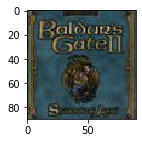

Cage-Face: Case 1 - The Mine
Genres: Adventure Indie
In Igdb Similar Games: False


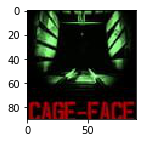

Ghostbusters
Genres: Arcade
In Igdb Similar Games: False


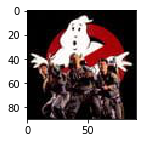

Itsuka, Kasanariau Ashita he: Shirou-hen
Genres: Visual Novel
In Igdb Similar Games: False


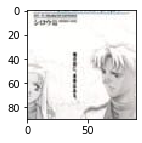

Little Nicky
Genres: Adventure
In Igdb Similar Games: False


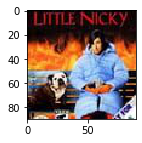

Ninja Pug
Genres: Indie Arcade
In Igdb Similar Games: False


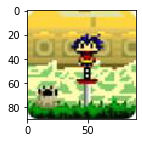

In [ ]:
name = "Baldur's Gate II: Shadows of Amn"
recommendations(df, name, word_embeddings)

In [ ]:
name = 'Sonic the Hedgehog 4: Episode I'

Feed Me Oil 2
Genres: Puzzle


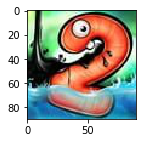

Kingdom Hearts Final Mix
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


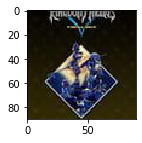

One Strike
Genres: Fighting Indie Arcade
In Igdb Similar Games: False


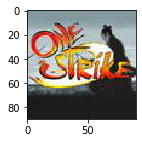

Sonic the Hedgehog 4: Episode I
Genres: Platform Adventure Arcade
In Igdb Similar Games: False


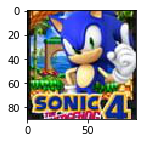

NieR: Automata - Day One Edition
Genres: Role-playing (RPG) Hack and slash/Beat 'em up
In Igdb Similar Games: False


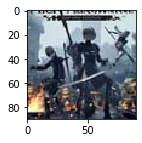

Liftoff: Drone Racing
Genres: Racing
In Igdb Similar Games: False


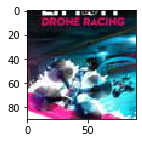

In [ ]:
recommendations(df, name, word_embeddings)

Dark Souls III
Genres: Role-playing (RPG) Adventure


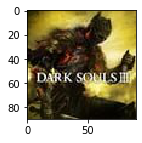

The Sims 4: Country Kitchen Kit
Genres: Role-playing (RPG) Simulator Adventure
In Igdb Similar Games: False


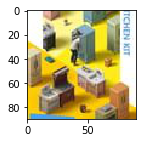

Mortyr II
Genres: Shooter
In Igdb Similar Games: False


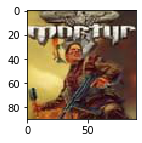

Camped Out!
Genres: Simulator Adventure Indie Arcade
In Igdb Similar Games: False


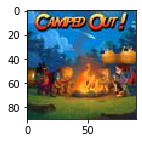

Mira: The Legend of the Djinns
Genres: Platform Puzzle Role-playing (RPG) Adventure Indie
In Igdb Similar Games: False


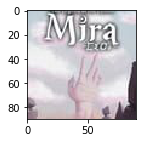

Thousand Arms
Genres: Role-playing (RPG)
In Igdb Similar Games: False


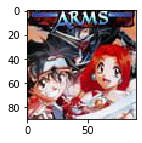

In [ ]:
recommendations(df, "Dark Souls III", word_embeddings)

Star Wars: The Old Republic - Shadow of Revan
Genres: Role-playing (RPG) Adventure


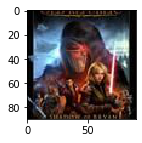

Wizardry: The Return of Werdna - The Fourth Scenario
Genres: Role-playing (RPG)
In Igdb Similar Games: False


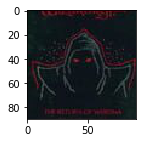

Akiba's Trip: Hellbound & Debriefed
Genres: Fighting Role-playing (RPG) Adventure Arcade
In Igdb Similar Games: False


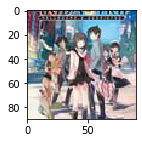

Chocobo's Dungeon 2
Genres: Role-playing (RPG) Strategy Adventure
In Igdb Similar Games: False


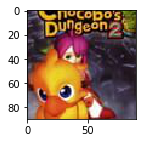

DUSK
Genres: Shooter Adventure Indie
In Igdb Similar Games: False


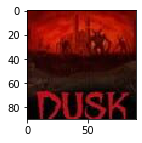

Cyberpunk: The Arasaka's Plot
Genres: Shooter Platform
In Igdb Similar Games: False


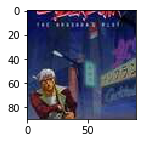

In [ ]:
recommendations(df, 'Star Wars: The Old Republic - Shadow of Revan', word_embeddings)

####Summary - Storyline

In [ ]:
model = train_with_corpus(corpus_summary_storyline)

In [ ]:
word_embeddings = vectors(df, 'summary_storyline', model)

In [ ]:
get_similiar_games("Baldur's Gate II: Shadows of Amn")

["Baldur's Gate: Dark Alliance II",
 'Diablo',
 'Neverwinter Nights 2',
 'Neverwinter Nights',
 'The Elder Scrolls V: Skyrim',
 'Icewind Dale',
 'Planescape: Torment',
 'Icewind Dale II',
 'Pillars of Eternity',
 'Torchlight']

Baldur's Gate II: Shadows of Amn
Genres: Role-playing (RPG)


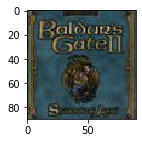

Baldur's Gate
Genres: Role-playing (RPG)
In Igdb Similar Games: False


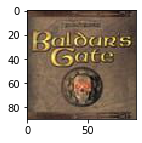

Dragon Age: Origins
Genres: Role-playing (RPG)
In Igdb Similar Games: False


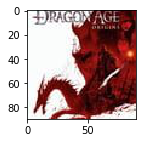

Death Gate
Genres: Puzzle Adventure
In Igdb Similar Games: False


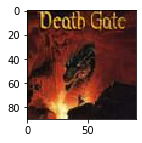

.hack//G.U. Vol. 1: Rebirth
Genres: Role-playing (RPG)
In Igdb Similar Games: False


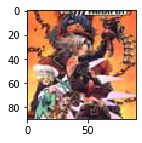

Baldur's Gate: Dark Alliance II
Genres: Role-playing (RPG) Hack and slash/Beat 'em up Adventure
In Igdb Similar Games: True


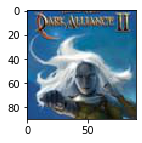

In [ ]:
name = "Baldur's Gate II: Shadows of Amn"
recommendations(df, name, word_embeddings)

In [ ]:
name = 'Sonic the Hedgehog 4: Episode I'

Sonic the Hedgehog 4: Episode I
Genres: Platform Adventure Arcade


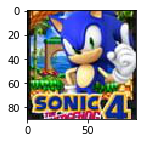

Sonic the Hedgehog 3 & Knuckles
Genres: Platform
In Igdb Similar Games: False


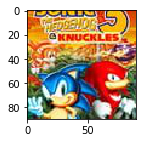

Sonic the Hedgehog 3
Genres: Platform Adventure
In Igdb Similar Games: False


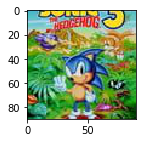

Five Nights at Sonic's Collection
Genres: Indie
In Igdb Similar Games: False


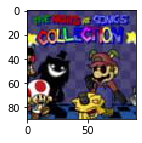

Sonic Generations: White Time and Space 20th Anniversary Set
Genres: Platform Adventure
In Igdb Similar Games: False


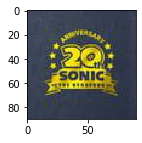

Sonic: Before the Sequel
Genres: Platform Adventure
In Igdb Similar Games: False


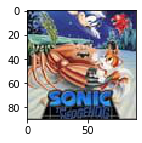

In [ ]:
recommendations(df, name, word_embeddings)

Dark Souls III
Genres: Role-playing (RPG) Adventure


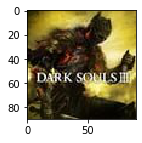

Dark Souls III: Day One Edition
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


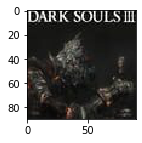

Animal Rescuer
Genres: Fighting Role-playing (RPG) Adventure Indie
In Igdb Similar Games: False


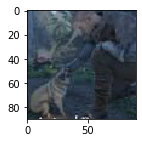

DEMON SKIN
Genres: Role-playing (RPG) Hack and slash/Beat 'em up Adventure Indie
In Igdb Similar Games: False


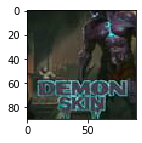

Sugar Fever
Genres: Puzzle
In Igdb Similar Games: False


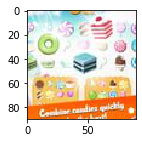

Camped Out!
Genres: Simulator Adventure Indie Arcade
In Igdb Similar Games: False


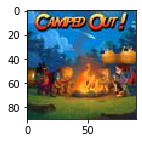

In [ ]:
recommendations(df, "Dark Souls III", word_embeddings)

Star Wars: The Old Republic - Shadow of Revan
Genres: Role-playing (RPG) Adventure


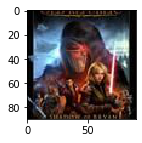

Star Wars: The Old Republic - Onslaught
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


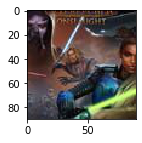

Star Wars: Knights of the Old Republic II - The Sith Lords
Genres: Role-playing (RPG) Strategy Adventure
In Igdb Similar Games: False


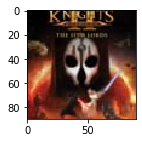

Star Wars: The Old Republic
Genres: Role-playing (RPG)
In Igdb Similar Games: False


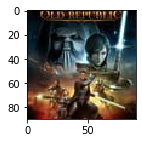

Star Wars: The Old Republic - Knights of the Fallen Empire
Genres: Role-playing (RPG)
In Igdb Similar Games: False


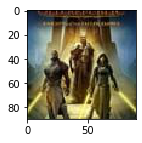

Star Wars: Knights of the Old Republic
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


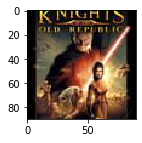

In [ ]:
recommendations(df, 'Star Wars: The Old Republic - Shadow of Revan', word_embeddings)

####Genres - Summary - Storyline

In [ ]:
model = train_with_corpus(corpus_gnr_smry_stry)

In [ ]:
word_embeddings = vectors(df, 'gnr_smry_stry', model)

Baldur's Gate II: Shadows of Amn
Genres: Role-playing (RPG)


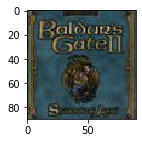

Baldur's Gate
Genres: Role-playing (RPG)
In Igdb Similar Games: False


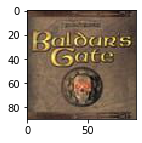

Dragon Age: Origins
Genres: Role-playing (RPG)
In Igdb Similar Games: False


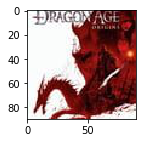

Death Gate
Genres: Puzzle Adventure
In Igdb Similar Games: False


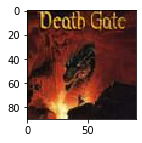

.hack//G.U. Vol. 1: Rebirth
Genres: Role-playing (RPG)
In Igdb Similar Games: False


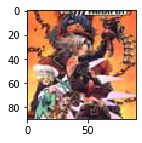

Baldur's Gate: Dark Alliance II
Genres: Role-playing (RPG) Hack and slash/Beat 'em up Adventure
In Igdb Similar Games: True


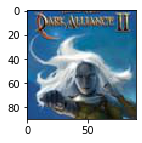

In [ ]:
name = "Baldur's Gate II: Shadows of Amn"
recommendations(df, name, word_embeddings)

In [ ]:
name = 'Sonic the Hedgehog 4: Episode I'

Sonic the Hedgehog 4: Episode I
Genres: Platform Adventure Arcade


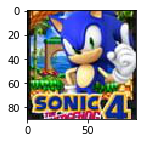

Sonic the Hedgehog 3
Genres: Platform Adventure
In Igdb Similar Games: False


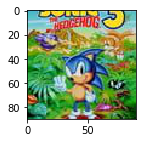

Sonic the Hedgehog 3 & Knuckles
Genres: Platform
In Igdb Similar Games: False


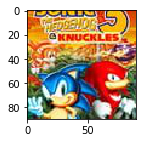

Sonic: Before the Sequel
Genres: Platform Adventure
In Igdb Similar Games: False


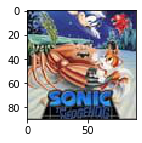

Sonic Advance 2
Genres: Platform Adventure
In Igdb Similar Games: False


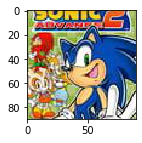

Sonic Generations: White Time and Space 20th Anniversary Set
Genres: Platform Adventure
In Igdb Similar Games: False


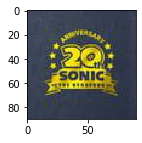

In [ ]:
recommendations(df, name, word_embeddings)

Dark Souls III
Genres: Role-playing (RPG) Adventure


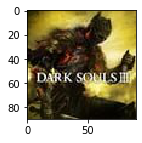

Dark Souls III: Day One Edition
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


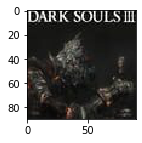

Animal Rescuer
Genres: Fighting Role-playing (RPG) Adventure Indie
In Igdb Similar Games: False


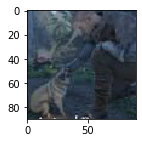

DEMON SKIN
Genres: Role-playing (RPG) Hack and slash/Beat 'em up Adventure Indie
In Igdb Similar Games: False


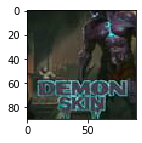

Camped Out!
Genres: Simulator Adventure Indie Arcade
In Igdb Similar Games: False


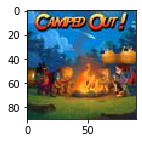

Sugar Fever
Genres: Puzzle
In Igdb Similar Games: False


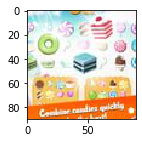

In [ ]:
recommendations(df, "Dark Souls III", word_embeddings)

Star Wars: The Old Republic - Shadow of Revan
Genres: Role-playing (RPG) Adventure


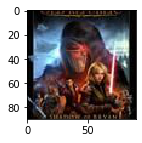

Star Wars: The Old Republic - Onslaught
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


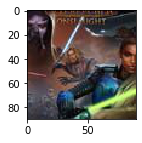

Star Wars: Knights of the Old Republic II - The Sith Lords
Genres: Role-playing (RPG) Strategy Adventure
In Igdb Similar Games: False


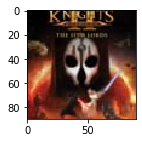

Star Wars: The Old Republic
Genres: Role-playing (RPG)
In Igdb Similar Games: False


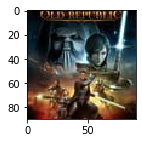

Star Wars: The Old Republic - Knights of the Fallen Empire
Genres: Role-playing (RPG)
In Igdb Similar Games: False


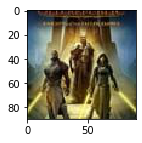

Star Wars: Knights of the Old Republic
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


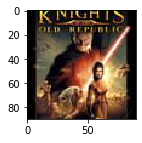

In [ ]:
recommendations(df, 'Star Wars: The Old Republic - Shadow of Revan', word_embeddings)

#### Name - Genres - Summary - Storyline

In [ ]:
model = train_with_corpus(corpus_nm_gnr_smry_stry)

In [ ]:
word_embeddings = vectors(df, 'nm_gnr_smry_stry', model)

Baldur's Gate II: Shadows of Amn
Genres: Role-playing (RPG)


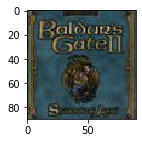

Baldur's Gate
Genres: Role-playing (RPG)
In Igdb Similar Games: False


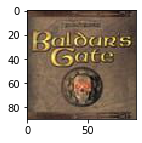

Dragon Age: Origins
Genres: Role-playing (RPG)
In Igdb Similar Games: False


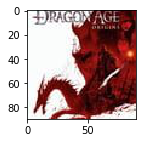

Death Gate
Genres: Puzzle Adventure
In Igdb Similar Games: False


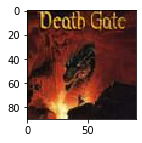

.hack//G.U. Vol. 1: Rebirth
Genres: Role-playing (RPG)
In Igdb Similar Games: False


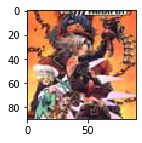

Baldur's Gate: Dark Alliance II
Genres: Role-playing (RPG) Hack and slash/Beat 'em up Adventure
In Igdb Similar Games: True


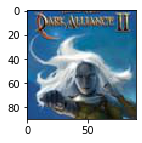

In [ ]:
name = "Baldur's Gate II: Shadows of Amn"
recommendations(df, name, word_embeddings)

In [ ]:
name = 'Sonic the Hedgehog 4: Episode I'

Sonic the Hedgehog 4: Episode I
Genres: Platform Adventure Arcade


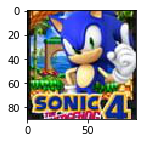

Sonic the Hedgehog 3
Genres: Platform Adventure
In Igdb Similar Games: False


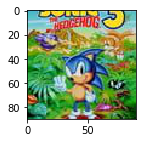

Sonic the Hedgehog 3 & Knuckles
Genres: Platform
In Igdb Similar Games: False


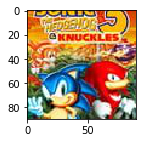

Sonic: Before the Sequel
Genres: Platform Adventure
In Igdb Similar Games: False


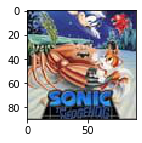

Sonic: After the Sequel
Genres: Platform Adventure
In Igdb Similar Games: False


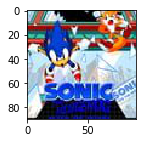

Five Nights at Sonic's Collection
Genres: Indie
In Igdb Similar Games: False


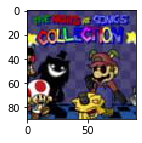

In [ ]:
recommendations(df, name, word_embeddings)

Dark Souls III
Genres: Role-playing (RPG) Adventure


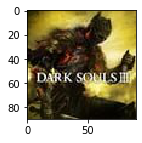

Dark Souls III: Day One Edition
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


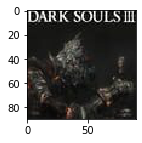

Animal Rescuer
Genres: Fighting Role-playing (RPG) Adventure Indie
In Igdb Similar Games: False


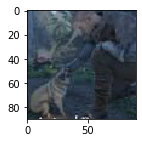

DEMON SKIN
Genres: Role-playing (RPG) Hack and slash/Beat 'em up Adventure Indie
In Igdb Similar Games: False


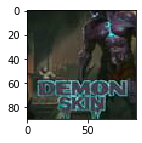

Camped Out!
Genres: Simulator Adventure Indie Arcade
In Igdb Similar Games: False


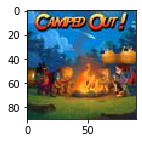

Sugar Fever
Genres: Puzzle
In Igdb Similar Games: False


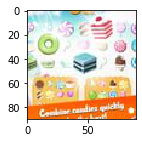

In [ ]:
recommendations(df, "Dark Souls III", word_embeddings)

Star Wars: The Old Republic - Shadow of Revan
Genres: Role-playing (RPG) Adventure


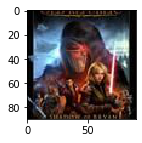

Star Wars: The Old Republic - Onslaught
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


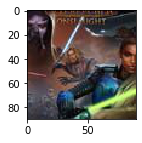

Star Wars: Knights of the Old Republic II - The Sith Lords
Genres: Role-playing (RPG) Strategy Adventure
In Igdb Similar Games: False


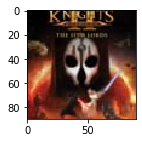

Star Wars: The Old Republic
Genres: Role-playing (RPG)
In Igdb Similar Games: False


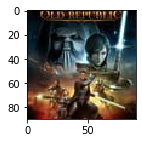

Star Wars: Knights of the Old Republic
Genres: Role-playing (RPG) Adventure
In Igdb Similar Games: False


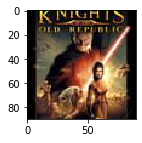

Star Wars: The Old Republic - Knights of the Fallen Empire
Genres: Role-playing (RPG)
In Igdb Similar Games: False


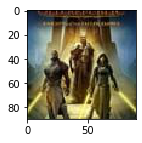

In [ ]:
recommendations(df, 'Star Wars: The Old Republic - Shadow of Revan', word_embeddings)